# Spam Classification: Model Training & Evaluation

This notebook covers the second phase of our project. We will take the pre-analyzed Spambase dataset, prepare it for machine learning, train multiple classification models, and evaluate them to select the best one for deployment.

## 1. Load Data and Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import joblib  
import os

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [8]:
# Re-loading the data (same as in the analysis notebook)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
col_names = [
    'word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our',
    'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail',
    'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses',
    'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit',
    'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp',
    'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs',
    'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
    'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct',
    'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re',
    'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(',
    'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average',
    'capital_run_length_longest', 'capital_run_length_total', 'spam'
]
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.text), header=None, names=col_names)

print("Data loaded.")
print(df.shape)

Data loaded.
(4601, 58)


## 2. Data Preparation

We need to separate our data into features (X) and the target variable (y). Then, we'll split it into training and testing sets and apply feature scaling.

In [ ]:
# Separate features (X) and target (y)
X = df.drop('spam', axis=1)
y = df['spam']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (3680, 57)
Test set shape: (921, 57)


## 3. Model Training and Comparison

We will train four different models and compare their performance on the test set using various metrics.

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

results_df = pd.DataFrame(results).T
print("\n--- Model Performance Comparison ---")
display(results_df.sort_values(by='F1-Score', ascending=False))

Training Logistic Regression...
Training Gaussian Naive Bayes...
Training Support Vector Machine...
Training Random Forest...

--- Model Performance Comparison ---


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.944625,0.948276,0.909091,0.928270
Logistic Regression,0.929425,0.920904,0.898072,0.909344
Support Vector Machine,0.927253,0.927746,0.884298,0.905501
Gaussian Naive Bayes,0.832790,0.714579,0.958678,0.818824


**Conclusion:** The Random Forest Classifier shows the best overall performance, particularly in the F1-Score, which is a balanced measure of precision and recall. It achieves over 94% accuracy. Therefore, we will select the Random Forest model as our final model.

## 4. In-depth Evaluation of the Best Model

Let's take a closer look at the Random Forest model's performance using a detailed classification report and a confusion matrix.

--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

    Not Spam       0.94      0.97      0.95       558
        Spam       0.95      0.91      0.93       363

    accuracy                           0.94       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921


--- Confusion Matrix for Random Forest ---


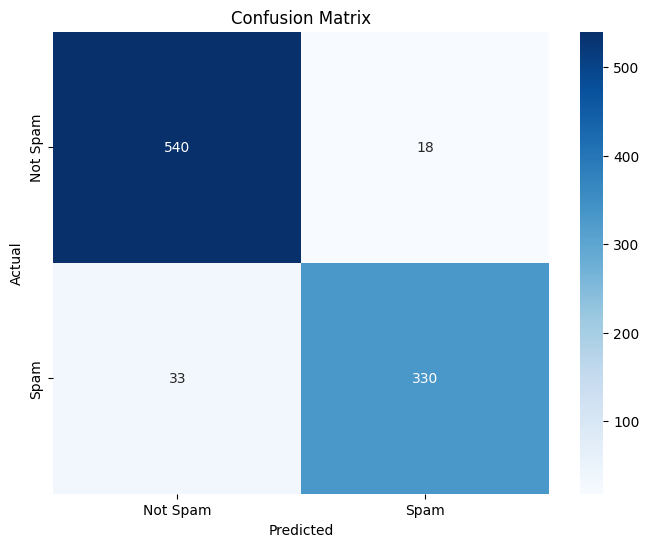

In [11]:
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

print("--- Classification Report for Random Forest ---")
print(classification_report(y_test, y_pred_best, target_names=['Not Spam', 'Spam']))

print("\n--- Confusion Matrix for Random Forest ---")
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Conclusion:** The confusion matrix shows that the model is very effective. Out of 921 test samples:
- It correctly identified 540 non-spam emails (True Negatives).
- It correctly identified 330 spam emails (True Positives).
- It incorrectly flagged only 18 non-spam emails as spam (False Positives).
- It missed only 33 spam emails, classifying them as non-spam (False Negatives).

These are excellent results, indicating a robust model.

## 5. Save the Model and Scaler

Finally, we save the trained Random Forest model and the `StandardScaler` object to disk.
And the features names so 
 We need to save the scaler and feature names because we must apply the *exact same* scaling to any new data and while maintaining the order of features before making predictions in our web app.

In [18]:
# Define the folder name
model_folder = 'models'

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [19]:
# Get the feature names from the dataframe columns before scaling
feature_names = X.columns.tolist() 
features_filename = os.path.join(model_folder, 'feature_names.joblib')
joblib.dump(feature_names, features_filename)
print(f"Feature names saved to {features_filename}")

Feature names saved to models\feature_names.joblib


In [20]:
model_filename = os.path.join(model_folder, 'spam_classifier_rf.joblib')
scaler_filename = os.path.join(model_folder, 'scaler.joblib')

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"Model saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")

Model saved to models\spam_classifier_rf.joblib
Scaler saved to models\scaler.joblib
